<a href="https://colab.research.google.com/github/AdamChoong0095/Intelliharvest-code/blob/main/triangulation_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mapping methods

In [ ]:
import pyproj
import warnings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import RdYlGn,jet,RdBu
from scipy.spatial import Delaunay
import pandas as pd

## Triangulation method

Estimated location of target: [5.00000007 2.48220473]


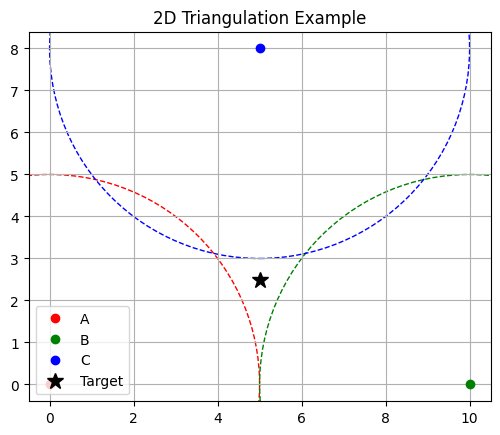

In [ ]:
#triangulation example
from scipy.optimize import minimize
# Reference points and distances
points = {
    'A': {'coords': np.array([0, 0]), 'dist': 5},
    'B': {'coords': np.array([10, 0]), 'dist': 5},
    'C': {'coords': np.array([5, 8]), 'dist': 5},
}

# Objective: minimize total error from all distance constraints
def error_fn(guess):
    x, y = guess
    total_error = 0
    for p in points.values():
        px, py = p['coords']
        expected = p['dist']
        actual = np.linalg.norm(np.array([x, y]) - np.array([px, py]))
        total_error += (actual - expected) ** 2
    return total_error

# Initial guess (center of triangle)
initial_guess = [5, 4]

# Optimize
result = minimize(error_fn, initial_guess)
target = result.x
print("Estimated location of target:", target)

#Plotting
fig, ax = plt.subplots()
colors = ['r', 'g', 'b']
for i, (label, data) in enumerate(points.items()):
    x, y = data['coords']
    r = data['dist']
    ax.plot(x, y, 'o', label=label, color=colors[i])
    circle = plt.Circle((x, y), r, color=colors[i], fill=False, linestyle='--')
    ax.add_artist(circle)

ax.plot(*target, 'k*', markersize=12, label='Target')
ax.legend()
ax.set_aspect('equal')
plt.title("2D Triangulation Example")
plt.grid(True)
plt.show()

In [ ]:
villages=pd.concat([mh1,mh2])

Find the district and subdistrict and village in which the farm is based and the nearest 3 notable landmarks within that area for triangulation. We should be able to locate the farm if we have an approximate distance between the farm and these landmarks. Lets first get a whole tiff file of the state to do some superimposition

In [ ]:
#triangulate a selected subistrict in mumbai district, eg. mumbai subdistrict
trig_loc=villages[(villages['NAME']=='Kundal') & (villages['DISTRICT']=='Sangali')]

In [ ]:
trig_loc#district with largest sugarcane production in Maharashtra exact bounds and coordinates unknown
mumbai_coords= (19.0760,72.8777)#mumabi city approximate known coordinates
nashik_coords= (19.9973,73.7897)#nashik approximate known coordinates


<ipython-input-66-faa810203ff6>:32: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  [gdf_points.unary_union.buffer(2)], crs="EPSG:4326"


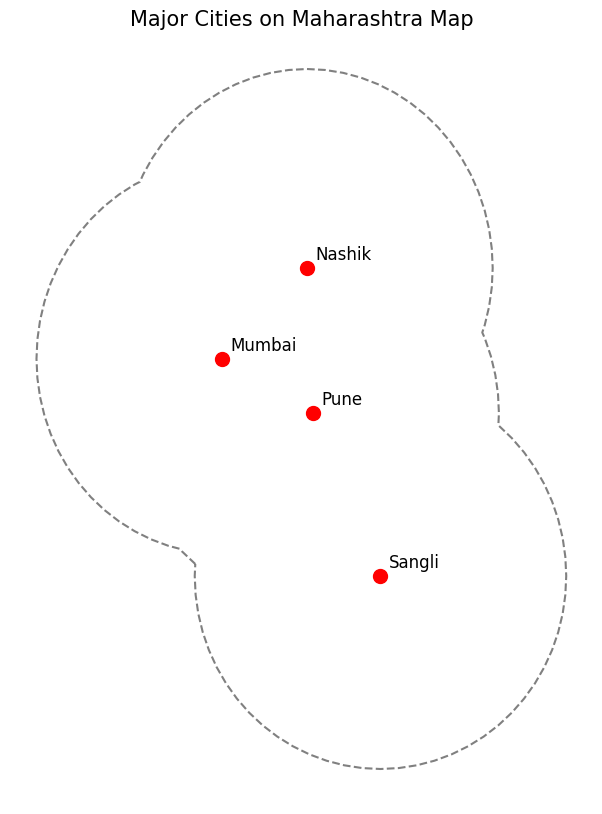

In [ ]:
#plotting cell on map of maharashtra bounds helps determine
#whether district chosen is appropriate for trying tirangulation
#relative scale only required
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point


# --- 1. Coordinates for the cities (lat, lon) ---
city_data = {
    "Mumbai": (19.0760, 72.8777),
    "Pune": (18.5204, 73.8567),
    "Nashik": (19.9973, 73.7897),
    "Sangli": (16.8524, 74.5815)
}

# --- 2. Create GeoDataFrame of city points ---
gdf_points = gpd.GeoDataFrame(
    {
        'city': list(city_data.keys()),
        'latitude': [city_data[city][0] for city in city_data],
        'longitude': [city_data[city][1] for city in city_data]
    },
    geometry=[Point(lon, lat) for lat, lon in city_data.values()],
    crs="EPSG:4326"
)

# --- 3. Load Maharashtra state boundary (optional, or use India boundary and clip) ---
# You can use Natural Earth data, or a custom shapefile of Maharashtra
# For demo, let's use a simplified bounding box for Maharashtra
maharashtra_bounds = gpd.GeoSeries(
    [gdf_points.unary_union.buffer(2)], crs="EPSG:4326"
)

# --- 4. Project for plotting with tiles ---
gdf_points_web = gdf_points.to_crs(epsg=3857)
maharashtra_bounds_web = maharashtra_bounds.to_crs(epsg=3857)

# --- 5. Plot ---
fig, ax = plt.subplots(figsize=(10, 10))

# Plot boundary approximation
maharashtra_bounds_web.boundary.plot(ax=ax, color='gray', linestyle='--')

# Plot cities
gdf_points_web.plot(ax=ax, color='red', markersize=100)

# Label cities
for x, y, label in zip(gdf_points_web.geometry.x, gdf_points_web.geometry.y, gdf_points_web['city']):
    ax.text(x + 10000, y + 10000, label, fontsize=12, color='black')

plt.title("Major Cities on Maharashtra Map", fontsize=15)
plt.axis('off')
plt.show()

In [ ]:
#use Haversine formula algorithm to get the missing information
import math

# Haversine formula to calculate distance between two points on the Earth
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Differences in coordinates
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Distance in kilometers
    distance = R * c
    return distance

# Coordinates of cities
cities = {
    "Mumbai": (19.0760, 72.8777),
    "Pune": (18.5204, 73.8567),
    "Nashik": (19.9973, 73.7897),
    "Sangli": (16.8524, 74.5815)
}

# Calculate distances
mumbai_pune = haversine(cities["Mumbai"][0], cities["Mumbai"][1], cities["Pune"][0], cities["Pune"][1])
nashik_pune = haversine(cities["Nashik"][0], cities["Nashik"][1], cities["Pune"][0], cities["Pune"][1])
sangli_pune = haversine(cities["Sangli"][0], cities["Sangli"][1], cities["Pune"][0], cities["Pune"][1])

# Print distances
print(f"Distance between Mumbai and Pune: {mumbai_pune:.2f} km")
print(f"Distance between Nashik and Pune: {nashik_pune:.2f} km")
print(f"Distance between Sangli and Pune: {sangli_pune:.2f} km")

Distance between Mumbai and Pune: 120.15 km
Distance between Nashik and Pune: 164.37 km
Distance between Sangli and Pune: 200.74 km


[np.float64(17.3692), np.float64(73.2204)]
Estimated location of target: [18.47992006 73.80032451]


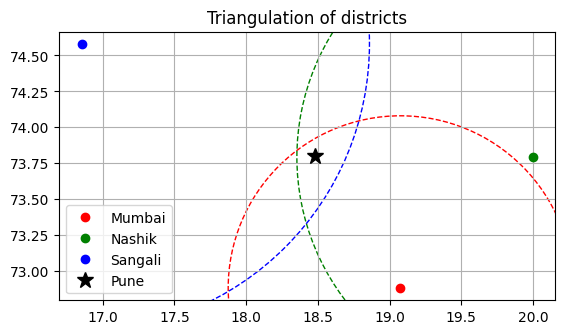

In [ ]:
#try triangulation algorithm to determine location of Pune City from other three major district landmarks
#each grid square is 100km
points = {
    'Mumbai': {'coords': np.array(list((19.0760, 72.8777))), 'dist': 1.2015},
    'Nashik': {'coords': np.array(list((19.9973, 73.7897))), 'dist': 1.6437},
    'Sangali': {'coords': np.array(list((16.8524, 74.5815))), 'dist': 2.0074},
}

# Initial guess (center of triangle)
initial_guess_latitude = np.round(np.random.uniform(17,19),4)#random uniform but within vincinity for simulation
initial_guess_longitude = np.round(np.random.uniform(73,74),4)
initial_guess=[initial_guess_latitude,initial_guess_longitude]
print(initial_guess)
# Optimize
result = minimize(error_fn, initial_guess)
target = result.x
print("Estimated location of target:", target)

#Plotting
fig, ax = plt.subplots()
colors = ['r', 'g', 'b']
for i, (label, data) in enumerate(points.items()):
    x, y = data['coords']
    r = data['dist']
    ax.plot(x, y, 'o', label=label, color=colors[i])
    circle = plt.Circle((x, y), r, color=colors[i], fill=False, linestyle='--')
    ax.add_artist(circle)

ax.plot(*target, 'k*', markersize=12, label='Pune')
ax.legend()
ax.set_aspect('equal')
plt.title("Triangulation of districts")
plt.grid(True)
plt.show()

Note that initial guess affects time complexity and convergence to a minimum may not occur if the guess is poor.

This triangulation algorithm can be applied to a relative grid system to locate exact locations of farms and crops. We need the following information for triangulation to work: the known location of three landmarks and the approximate distance from each to the target. If the target location is not known, find an approximate coordinate around the target and use Haversine algorithm to find the distances between the approximation to the target and the other three known points.